In [2]:
import sys
# sys.path.append('/home1/jrudoler/src/')
# from retrieval_help import create_baseline_events, free_epochs
import cmlreaders as cml
import numpy as np
import pandas as pd
from ptsa.data.filters import ButterworthFilter, MorletWaveletFilter
from ptsa.data.concat import concat
from scipy.stats import ttest_ind
from scipy.stats import zscore
# from irasa.IRASA import IRASA
import CMLDask as da
import xarray as xr

pd.options.display.max_columns = None
# sys.path.append('/home1/doughem/')

/home1/doughem/.conda/envs/ESTES2021/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
subjects = ['LTP449', 'LTP451', 'LTP453', 'LTP455', 'LTP457', 'LTP458', 'LTP462', 
            'LTP468', 'LTP470', 'LTP473', 'LTP474', 'LTP475', 'LTP476', 'LTP477']

In [4]:
from ptsa.data.timeseries import TimeSeries
LTP448_powers = TimeSeries.from_hdf('/scratch/nicls_cns/LTP448_encoding_powers.h5')
LTP449_powers = TimeSeries.from_hdf('/scratch/nicls_cns/LTP449_encoding_powers.h5')
LTP451_powers = TimeSeries.from_hdf('/scratch/nicls_cns/LTP451_encoding_powers.h5')
LTP453_powers = TimeSeries.from_hdf('/scratch/nicls_cns/LTP453_encoding_powers.h5')
LTP455_powers = TimeSeries.from_hdf('/scratch/nicls_cns/LTP455_encoding_powers.h5')
LTP457_powers = TimeSeries.from_hdf('/scratch/nicls_cns/LTP457_encoding_powers.h5')
LTP458_powers = TimeSeries.from_hdf('/scratch/nicls_cns/LTP458_encoding_powers.h5')
LTP462_powers = TimeSeries.from_hdf('/scratch/nicls_cns/LTP462_encoding_powers.h5')
LTP468_powers = TimeSeries.from_hdf('/scratch/nicls_cns/LTP468_encoding_powers.h5')
LTP470_powers = TimeSeries.from_hdf('/scratch/nicls_cns/LTP470_encoding_powers.h5')
LTP473_powers = TimeSeries.from_hdf('/scratch/nicls_cns/LTP473_encoding_powers.h5')
LTP474_powers = TimeSeries.from_hdf('/scratch/nicls_cns/LTP474_encoding_powers.h5')
LTP475_powers = TimeSeries.from_hdf('/scratch/nicls_cns/LTP475_encoding_powers.h5')
LTP476_powers = TimeSeries.from_hdf('/scratch/nicls_cns/LTP476_encoding_powers.h5')
LTP477_powers = TimeSeries.from_hdf('/scratch/nicls_cns/LTP477_encoding_powers.h5')

In [5]:
experiment = 'NiclsCourierReadOnly'

data = cml.get_data_index(kind = 'ltp')
data = data[(data['experiment']==experiment)].sort_values('session').reset_index()

full_pows = []
full_evs = None

for i, row in data.iterrows():
    # intialize data reader, load words events and buffered eeg epochs
    r = cml.CMLReader(subject=row['subject'], experiment=row['experiment'], session=row['session'])
    evs = r.load('task_events')
    full_evs = evs if full_evs is None else pd.concat([full_evs, evs], ignore_index=True)
full_evs = full_evs.query('subject in @subjects')

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [26]:
def spatial_CRP(dataframe, bins):
    #bins is a list of the bin labels that you want, the length of the list and names of these bins will be used in the function
    from scipy.spatial import distance_matrix
    return_df = pd.DataFrame(columns = ['subject', 'bins', 'actual_count', 'possible_count', 'probability'])
    df_list = []
    for i in dataframe.subject.unique():
        subject_df = dataframe.query('subject == @i')
        return_df.bins = bins
        return_df.subject = i
        return_df.actual_count = 0
        return_df.possible_count = 0
        loc_evs = subject_df[(subject_df.storeX!=-999)&(subject_df.store!='-999')]
        stores = loc_evs.groupby('store').agg('mean')[['storeX', 'storeZ']]
        dist_mat = distance_matrix(stores, stores)
        dist_df = pd.DataFrame(dist_mat, columns = stores.index, index = stores.index)
        full_distances = []
        for j in list(range(dist_df.shape[0])):
            for k in dist_df.iloc[j].tolist():
                full_distances.append(k)
        full_distances = list(set(full_distances))
        full_distances = pd.DataFrame(full_distances, columns = ['dist']).query('dist != 0').reset_index()
        bin_series, bin_nos = pd.qcut(full_distances.dist, q = len(bins), retbins = True)
        bin_nos = bin_nos[1:]
        deliveries = subject_df[subject_df.type=='WORD']
        recword = subject_df[subject_df.type=='REC_WORD'].reset_index().drop(columns='index')
        recword['pos'] = recword.groupby(['subject', 'session', 'trial']).cumcount()
        recword['repetition'] = 0
        recalled_stores = []
        for l, row in recword.iterrows():
            dd, sess, transition_store = row[['trial', 'session', 'store']]
            # new list, skip first recall and initialize
            if (row['pos']==0):
                recalled_stores = []
                # print("reset")
                if row['intrusion']==0:
                    recalled_stores.append(transition_store)
                    #print("transition:", transition_store)
                # list of stores with deliveries in current list
                store_list = deliveries[(deliveries.trial==dd)&(deliveries.session==sess)].store.unique()
                continue
            # skip intrusions
            if (row['intrusion']!=0)|(transition_store not in store_list):
                continue
            # skip repeats
            if transition_store in recalled_stores:
                recword.loc[l, 'repetition'] = 1
                continue
            # skip transition following intrusion or repeat but record recall
            if (recword.loc[l-1, 'intrusion']!=0)|(recword.loc[l-1, 'repetition']!=0):
                recalled_stores.append(transition_store)
                # print("transition:", transition_store)
                continue
            store_idx = stores.index.get_loc(recalled_stores[-1])
            stores['dist'] = dist_mat[store_idx]
            # only use stores with deliveries in current list
            # drop recalled stores (no repetitions)
            available = stores.loc[store_list].drop(index=recalled_stores)['dist']
            available = pd.DataFrame(available).reset_index()
            bin_df = pd.DataFrame({'bin_nos': bin_nos, 'labels' : bins})
            available['bins'] = ''
            for m in list(range(available.shape[0])):
                for n in list(range(bin_df.shape[0])):
                    if available.dist.iloc[m] <= bin_df.bin_nos.iloc[n]:
                        available.bins.iloc[m] = bin_df.labels.iloc[n]
                        break
            for o in bins:
                if o not in available.bins.value_counts():
                    continue
                return_df.loc[return_df.bins == o, 'possible_count'] += 1
            recalled_stores.append(transition_store)
            transition_bin = available.bins.loc[available.store == transition_store].values[0]
            return_df.loc[return_df.bins == transition_bin, 'actual_count'] += 1
        return_df.probability = return_df.actual_count/return_df.possible_count
        df_list.append(return_df.copy()) #add a copy of the return_df to the list
        
        #All of these lines clear the data from a subject before populating these same dataframes with the next subject's
        #data. That is why we add a copy of return_df above instead of the actual thing
        subject_df = subject_df.iloc[0:0]
        return_df = pd.DataFrame(columns = return_df.columns)

    final_return = pd.concat(df_list)   
    return final_return

In [27]:
test5 = spatial_CRP(full_evs, ['very near', 'near', 'intermediate', 'far', 'veryfar'])

/home1/doughem/.conda/envs/ESTES2021/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Text(0, 0.5, 'Conditional response probability')

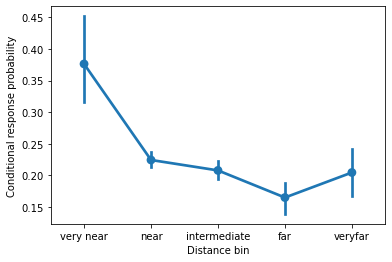

In [28]:
spatialCRP_curve = plt.figure()
ax1 = sns.pointplot(data=test5, x='bins', y='probability', marker = 'o')
plt.xlabel('Distance bin')
plt.ylabel('Conditional response probability')

In [10]:
test10 = spatial_CRP(full_evs, ['nearest', 'very near', 'near', 'somewhat near', 'intermediate near', 'intermediate far', 'somewhat far', 'far', 'very_far', 'farthest'])

/home1/doughem/.conda/envs/ESTES2021/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Text(0, 0.5, 'Conditional response probability')

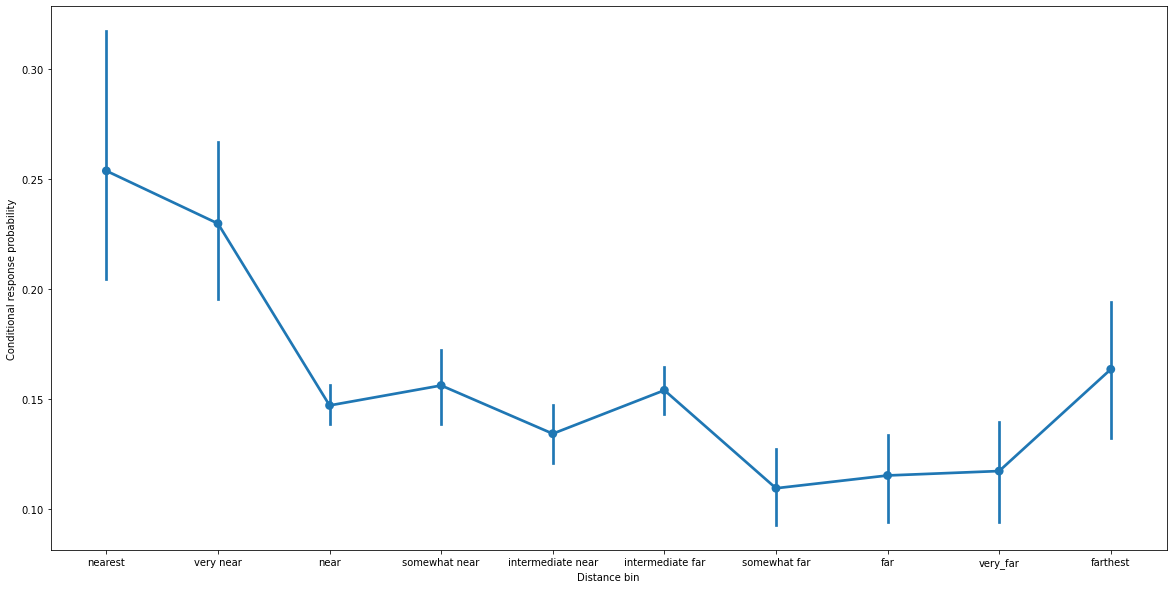

In [11]:
spatialCRP_curve = plt.figure(figsize = (20, 10))
ax1 = sns.pointplot(data=test10, x='bins', y='probability', marker = 'o')
plt.xlabel('Distance bin')
plt.ylabel('Conditional response probability')

In [40]:
subset_events = full_evs.query('subject == "LTP477"')

In [41]:
from scipy.spatial import distance_matrix
loc_evs = subset_events[(subset_events.storeX!=-999)&(subset_events.storeZ!='-999')]
stores = loc_evs.groupby('store').agg('mean')[['storeX', 'storeZ']]
# create distance matrix
dist_mat = distance_matrix(stores, stores)
dist_df = pd.DataFrame(dist_mat, columns = stores.index, index = stores.index)

In [42]:
full_distances = []
for i in list(range(dist_df.shape[0])):
    for j in dist_df.iloc[i].tolist():
        full_distances.append(j)
full_distances = list(set(full_distances))
full_distances = pd.DataFrame(full_distances, columns = ['dist']).query('dist != 0').reset_index()['dist']

In [43]:
fifths_list = [full_distances.min(), full_distances.quantile(0.2), full_distances.quantile(0.4), full_distances.quantile(0.6), full_distances.quantile(0.8), full_distances.max()]

In [11]:
def spatial_CRP(dataframe, bin_nos):
    from scipy.spatial import distance_matrix
    return_df = pd.DataFrame(columns = ['subject', 'bins', 'actual_count', 'possible_count', 'probability'])
    bins = ['Very near','Near', 'Intermediate', 'Far', 'Very far']
    df_list = []
    for i in dataframe.subject.unique():
        subject_df = dataframe.query('subject == @i')
        return_df.bins = bins
        return_df.subject = i
        return_df.actual_count = 0
        return_df.possible_count = 0
        loc_evs = subject_df[(subject_df.storeX!=-999)&(subject_df.store!='-999')]
        stores = subject_df.groupby('store').agg('mean')[['storeX', 'storeZ']]
        dist_mat = distance_matrix(stores, stores)
        deliveries = subject_df[subject_df.type=='WORD']
        recword = subject_df[subject_df.type=='REC_WORD'].reset_index().drop(columns='index')
        recword['pos'] = recword.groupby(['subject', 'session', 'trial']).cumcount()
        recword['repetition'] = 0
        recalled_stores = []
        for j, row in recword.iterrows():
            dd, sess, transition_store = row[['trial', 'session', 'store']]
            # new list, skip first recall and initialize
            if (row['pos']==0):
                recalled_stores = []
                # print("reset")
                if row['intrusion']==0:
                    recalled_stores.append(transition_store)
                    #print("transition:", transition_store)
                # list of stores with deliveries in current list
                store_list = deliveries[(deliveries.trial==dd)&(deliveries.session==sess)].store.unique()
                continue
            # skip intrusions
            if (row['intrusion']!=0)|(transition_store not in store_list):
                continue
            # skip repeats
            if transition_store in recalled_stores:
                recword.loc[i, 'repetition'] = 1
                continue
            # skip transition following intrusion or repeat but record recall
            if (recword.loc[j-1, 'intrusion']!=0)|(recword.loc[j-1, 'repetition']!=0):
                recalled_stores.append(transition_store)
                # print("transition:", transition_store)
                continue
            store_idx = stores.index.get_loc(recalled_stores[-1])
            stores['dist'] = dist_mat[store_idx]
            # only use stores with deliveries in current list
            # drop recalled stores (no repetitions)
            available = stores.loc[store_list].drop(index=recalled_stores)['dist']
            available = pd.DataFrame(available).reset_index()
            available['bins'] = ''
            for k in list(range(available.shape[0])):
                if available.dist.iloc[k] < bin_nos[1]:
                    available.bins.iloc[k] = bins[0]
                elif (available.dist.iloc[k] > bin_nos[1]) & (available.dist.iloc[k] < bin_nos[2]):
                    available.bins.iloc[k] = bins[1]
                elif (available.dist.iloc[k] > bin_nos[2]) & (available.dist.iloc[k] < bin_nos[3]):
                    available.bins.iloc[k] = bins[2]
                elif (available.dist.iloc[k] > bin_nos[3]) & (available.dist.iloc[k] < bin_nos[4]):
                    available.bins.iloc[k] = bins[3]
                elif (available.dist.iloc[k] > bin_nos[4]) & (available.dist.iloc[k] < bin_nos[5]):
                    available.bins.iloc[k] = bins[4]
            for l in bins:
                if l not in available.bins.value_counts():
                    continue
                return_df.loc[return_df.bins == l, 'possible_count'] += 1
            transition_bin = available.bins.loc[available.store == transition_store].values[0]
            return_df.loc[return_df.bins == transition_bin, 'actual_count'] += 1
        return_df.probability = return_df.actual_count/return_df.possible_count
        df_list.append(return_df.copy()) #add a copy of the return_df to the list
        
        #All of these lines clear the data from a subject before populating these same dataframes with the next subject's
        #data. That is why we add a copy of return_df above instead of the actual thing
        subject_df = subject_df.iloc[0:0]
        return_df = pd.DataFrame(columns = return_df.columns)

    final_return = pd.concat(df_list)   
    return final_return

Text(0, 0.5, 'Conditional response probability')

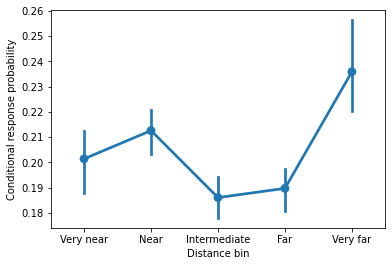

In [15]:
spatialCRP_curve = plt.figure()
ax1 = sns.pointplot(data=test, x='bins', y='probability', marker = 'o')
plt.xlabel('Distance bin')
plt.ylabel('Conditional response probability')